In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

# Dlnpyutils
from dlnpyutils.utils import bspline,mad,interp

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# functools
from functools import partial

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# pdb
import pdb

# tqdm 
from tqdm.notebook import tqdm

class Aetas():
    '''
    Aetas = A codE To calculate stellAr ageS
    
    A code to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,star_data,isochrones,ext_law='CCM89',rv=3.1,teff_extrap_limit=100,debug=False):
        
        '''
        Inputs:
        ------
                    star_data: Table (pandas dataframe or astropy table)
                               Observed and calculated properties of a star(s) with the 
                               following columns:
                               
                               'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'FE_H', 'FE_H_ERR',
                               'ALPHA_FE', 'ALPHA_FE_ERR', 'BP', 'G', 'RP', 'J', 'H', 'K',
                               'BP_ERR', 'G_ERR', 'RP_ERR', 'J_ERR', 'H_ERR', 'K_ERR', 
                               'DISTANCE'
                
                               'DISTANCE' must be in units of parsecs
                    
                   isochrones: Table (pandas dataframe or astropy table)
                               PARSEC isochrone table with the following columns:
                               
                               'MH', 'Mass', 'delta_int_IMF', 'logAge', 'logTe', 'logg', 
                               'BPmag', 'Gmag', 'RPmag', 'Jmag', 'Hmag', 'Ksmag', 'label'
                               
                               'delta_int_IMF' is the difference in adjacent 'int_IMF' 
                               values for each isochrone (i.e. int_IMF[i+1]-int_IMF[i])
                               with the last value repeated as the difference returns 
                               one less element.
                               
                               'label' is the evolutionary phase label given by PARSEC
                        
                      ext_law: string, optional
                               extinction law to use. Default is CCM89.

                               Available Extinction Laws: 
                               -------------------------

                               CCM89 - Cardelli, Clayton, & Mathis 1989
                               O94 - O'Donnell 1994
                               F99 - Fitzpatrick 1999
                               F04 - Fitzpatrick 2004
                               VCG04 - Valencic, Clayton, & Gordon 2004
                               GCC09 - Grodon, Cartledge, & Clayton 2009
                               M14 - Maiz Apellaniz et al 2014
                               F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                               D22 - Decleir et al. 2022
                        
                           rv: float, optional
                               Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                               (required to be 3.1 if ext_law = 'F99')
                        
            teff_extrap_limit: float
                               limit for maximum allowable temperature outside 
                               isochrone range that will be extrapolated 
                        
                        debug: bool
                               print useful information to the screen

        '''
        
        # Teff and log(g)
        self.teff = star_data['TEFF'] # temperature
        self.teff_err = star_data['TEFF_ERR'] # temperature error
        self.logg  = star_data['LOGG'] # log(g)
        self.logg_err = star_data['LOGG_ERR'] # log(g) error
        
        # Salaris corrected [Fe/H]
        sal_met = self.salaris_metallicity(star_data['FE_H'],star_data['FE_H_ERR'],
                                           star_data['ALPHA_FE'],star_data['ALPHA_FE_ERR'])
        
        self.salfeh,self.salfeh_err = sal_met[0],sal_met[1]
        
        # observed photometry
        self.obs_phot_labels = ['BP','G','RP','J','H','K']
        self.phot = 999999.0*np.ones(6)
        self.phot_err = 999999.0*np.ones(6)
        for i in range(6):
            self.phot[i] = star_data[self.obs_phot_labels[i]]
            self.phot_err[i] = star_data[self.obs_phot_labels[i]+'_ERR']
        
        # Distance modulus
        self.distmod = 5.0*np.log10(star_data['DISTANCE'])-5.0
        
        # PARSEC isochrones
        self.iso_phot_labels = ['BPmag','Gmag','RPmag','Jmag','Hmag','Ksmag']
        self.iso_interp_labels = ['BPmag','Gmag','RPmag','Jmag','Hmag','Ksmag','logg','delta_int_IMF']
        
        isochrones = isochrones[np.argsort(isochrones['logAge'])]
        
        #pdb.set_trace()
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        self.uniq_phases = np.unique(self.iso['label'])
                
        # Extinction
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K (microns)
        self.extlaw_coeff = self.extcoeff(law=ext_law,rv=self.rv)
        
        # Other
        self.debug = debug
        self.teff_extrap_limit = teff_extrap_limit 
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value.

        Inputs:
        ------
             data: array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value.

        Inputs:
        ------
              data: array-like
                    data to search through

             value: float or int
                    value of interest

        Output:     
        ------     
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    ###################
    ### Metallicity ###
    ###################
    
    def salaris_metallicity(self,metal,metal_err,alpha,alpha_err):
        '''
        Calculate the Salaris corrected metallicity (Salaris et al. 1993) using updated solar 
        parameters from Asplund et al. 2021.
        
        Inputs:
        ------
                 metal: float
                        [Fe/H] of a star
                         
             metal_err: float
                        error in [Fe/H] of a star
                     
                 alpha: float
                        [alpha/Fe] of a star
                 
             alpha_err: float
                        error in [alpha/Fe] of a star
                        
        Outputs:
        -------
                salfeh: float
                        Salaris corrected metallicity
            
            salfeh_err: float
                        error in Salaris corrected metallicity
            
        '''
        salfeh = metal+np.log10(0.659*(10**alpha)+0.341)
        salfeh_err = np.sqrt(metal_err**2+(10**alpha/(0.517372+10**alpha)*alpha_err)**2)
        
        return salfeh, salfeh_err
    
    ##################
    ### Extinction ###
    ##################
    
    def extcoeff(self,law='CCM89',rv=3.1):

        '''
        Calculate the relative extincion law coefficients for the BP, G, RP, J, H, Ks bands
        for a given Rv and extinction law.

        Input:
        -----
                    rv: float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
                        
                   law: str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
        Output:
        ------
             ext_coeff: float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinction(self):#,label):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and Ks bands
        
        Input:
        -----
            #label: int
                   label for PARSEC evolutionary phase
                   
                   Available Labels:
                   ----------------
                   0 = PMS, pre main sequence
                   1 = MS, main sequence
                   2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                   3 = RGB, red giant branch, or the quick stage of red giant for 
                   intermediate+massive stars
                   4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                   intermediate+massive stars
                   5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                   6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                   7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                   massive stars
                   8 = TPAGB, the thermally pulsing asymptotic giant branch
                   9 = post-AGB (in preparation!)
        
        Output:
        ------
              ext: 6x2 array
                   first column is the extinction values and the second is the errors
        '''
        
        if self.debug:
            print('### Running Aetas.extinction() ###')
            print('Inputs from Aetas.__init__()')
            print('Salaris Corrected Metallicity:',self.salfeh)
            print('Temperature:',self.teff)

        # isochrone magnitude labels
        color_labels = np.array([['BPmag','Gmag','Gmag','Gmag','Gmag'],
                                 ['Gmag','RPmag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 500 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.)))#&
                           #(self.iso['label']==label))
        
        iso_ = self.iso[teffcut]
        
        # check to make sure there are enough isochrone points
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones(6)
            self.ext_err = 999999.0*np.ones(6)
            return 999999.0*np.ones(6), 999999.0*np.ones(6)
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        if self.debug:
            print('Calculated Observed Colors:')
            print('Observed Colors:',obs_colors)
            print('Observed Color Errors:',obs_colors_err)
        
        # create "reddening" vector (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        # relative extinction vector
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
        # calculate the intrinsic colors using a b-spline
        iso_colors = 999999.0*np.ones(5)
        iso_colors_deriv = 999999.0*np.ones(5)
        
        # determine if the Teff is in the isochrone range
        use_lgteff = np.log10(self.teff)
        if use_lgteff < np.min(iso_['logTe']) or use_lgteff > np.max(iso_['logTe']):
            use_lgteff = closest(iso_['logTe'],np.log10(self.teff))
        
        # Interpolate the color-Teff relation using a b-spline
        logTe = iso_['logTe']
        for i in range(5):
            try:
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])

                bspl = bspline(logTe,color)
                iso_colors[i] = bspl(use_lgteff)
                iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
            except:
                try:
                    bspl = bspline(logTe,color,extrapolate=True)
                    iso_colors[i] = bspl(use_lgteff)
                    iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
                except:
                    iso_colors[i] = 999999.0
                    iso_colors_deriv[i] = 999999.0
                    
        if self.debug:
            print('Isochrone Colors:',iso_colors)
                
        # calculate the extinctions and errors
        color_diff = obs_colors-iso_colors
        color_errs = np.abs((iso_colors_deriv*self.teff_err)/(self.teff*np.log(10)))
        color_diff_err = np.sqrt(obs_colors_err**2+color_errs**2)
        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            if self.debug:
                print('All Colors are bad')
                print('Max Iso Teff:',10**np.nanmax(iso_['logTe']))
                print('Min Iso Teff:',10**np.nanmin(iso_['logTe']))
                print('Obs Teff:',self.teff)
            
            self.ext = 999999.0*np.ones(6)
            self.ext_err = 999999.0*np.ones(6)
            return 999999.0*np.ones(6), 999999.0*np.ones(6)
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        ext = 999999.0*np.ones(6)
        ext_err = 999999.0*np.ones(6)
        ext = ext_vec*ag
        ext_err = ext_vec*ag_err
        
        # chisq
        iso_colors_extincted = iso_colors+red_vec*ag
        ext_chi = sum((obs_colors-iso_colors_extincted)**2/obs_colors_err**2)
        
        self.ext = ext
        self.ext_err = ext_err
        
        if self.debug:
            print('A(G)+ Error:',ag,ag_err)
            print('All Extinctions:',ext)
            print('chisq:',ext_chi)
            print('resid:',obs_colors-iso_colors_extincted)
        
        return ext, ext_err
    
    ####################################################
    ### Mags, Log(g), Age, delta int_IMF, and Masses ###
    ####################################################
    
    def teff_2_appmags_logg(self,teff,age,label,extrap):
        '''
        Calculate the apparent magnitudes and log(g) of a star given its teff and age.
        This function also calculates the change in 'int_IMF' a star woould have, though
        this is not returned, but is stored in self.delta_int_IMF.
        
        Input:
        -----
              teff: float
                    temperature of a star
            
               age: float
                    age in Gyr of a star
            
             label: int
                    label for PARSEC evolutionary phase
                   
                    Available Labels:
                    ----------------
                    0 = PMS, pre main sequence
                    1 = MS, main sequence
                    2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                    3 = RGB, red giant branch, or the quick stage of red giant for 
                    intermediate+massive stars
                    4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                    intermediate+massive stars
                    5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                    6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                    7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                    massive stars
                    8 = TPAGB, the thermally pulsing asymptotic giant branch
                    9 = post-AGB (in preparation!)
                    
            
            extrap: bool
                    False: no extrapolation
                    True: extrapolate
        
        Output:
        ------
             calc_: 7x1 array
                    Calculated apparent magnitudes and log(g) of a star
        
        '''
        
        extincts = self.ext
        
        if extincts[1] > 100.:
            if debug:
                print('Bad extinctions replaced with 0.0')
            extincts *= 0.0
        
        if self.debug:
            print('Running Aetas.teff_2_appmags()')
            print('Teff:',teff)
            print('Extinctions:',extincts)
        
        # Set up
        lgteff = np.log10(teff)
        lgage = np.log10(age*10**9)
            
        iso = self.iso[np.where(self.iso['label']==label)]
            
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        age_idx = np.asarray(age_idx)
        
        # find 2 closest ages in the ischrones
        lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
        if self.debug:
            print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

        # younger isochrone
        aidx_lo, = np.where(self.uniq_ages==lgage_lo)
        iso_lo = iso[age_idx[int(aidx_lo)][0]:age_idx[int(aidx_lo)][1]]

        # older isochrone
        aidx_hi, = np.where(self.uniq_ages==lgage_hi)
        iso_hi = iso[age_idx[int(aidx_hi)][0]:age_idx[int(aidx_hi)][1]]

        ### Temperature Check
        extrap_lo = extrap
        extrap_hi = extrap
        self.did_extrap = 0

        if (10**min(iso_lo['logTe'])-self.teff > self.teff_extrap_limit or 
            self.teff - 10**max(iso_lo['logTe']) > self.teff_extrap_limit):

            if self.debug:
                print('outside iso_lo')
                print('Age',10**lgage_lo/10**9)
                print('max iso_lo',max(iso_lo['logTe']))
                print('min iso_lo',min(iso_lo['logTe']))
                print('Teff',np.log10(self.teff))
                print('Lower - Teff',10**min(iso_lo['logTe'])-self.teff)

            self.delta_int_IMF = 999999.0
            return 999999.0*np.ones(7)

        if (10**min(iso_hi['logTe'])-self.teff > self.teff_extrap_limit or 
            self.teff - 10**max(iso_hi['logTe']) > self.teff_extrap_limit):
            if self.debug:
                print('outside iso_hi')
                print('max iso_hi',max(iso_hi['logTe']))
                print('min iso_hi',min(iso_hi['logTe']))
                print('Teff',np.log10(self.teff))
                print('Lower - Teff',10**min(iso_hi['logTe'])-self.teff)

            self.delta_int_IMF = 999999.0
            return 999999.0*np.ones(7)

        ### use a b-spline to get the apparent mags, log(g), and int_IMF
        age_lo = 10**lgage_lo/10**9
        age_hi = 10**lgage_hi/10**9
        calc_lo = 999999.0*np.ones(8)
        calc_hi = 999999.0*np.ones(8)

        for i in range(len(self.iso_interp_labels)):

            # younger age spline
            if extrap_lo:
                self.did_extrap=1
                
                try:
                    spl_lo = interp(iso_lo['logTe'],iso_lo[self.iso_interp_labels[i]],lgteff,
                                  assume_sorted=False,extrapolate=True)

                    if i <= 5:
                        calc_lo[i] = spl_lo+self.distmod+extincts[i]
                        
                    else:
                        calc_lo[i] = spl_lo

                except:
                    calc_lo[i] = 999999.0

            else:
                if debug:
                    print('no extrap lo')
                try:
                    spl_lo = bspline(iso_lo['logTe'],iso_lo[self.iso_interp_labels[i]])(lgteff)
                    
                    if i<= 5:
                        calc_lo[i] = spl_lo+self.distmod+extincts[i]
                        
                    else:
                        calc_lo[i] = spl_lo

                except:
                    calc_lo[i] = 999999.0

            ### older age spline 
            if extrap_hi:
                self.did_extrap=1
                
                try:
                    spl_hi = interp(iso_hi['logTe'],iso_hi[self.iso_interp_labels[i]],lgteff,
                                  assume_sorted=False,extrapolate=True)

                    if i <= 5:
                        calc_hi[i] = spl_hi+self.distmod+extincts[i]
                    
                    else:
                        calc_hi[i] = spl_hi 

                except:
                    calc_hi[i] = 999999.0

            else:
                try:
                    spl_hi = bspline(iso_hi['logTe'],iso_hi[self.iso_interp_labels[i]])(lgteff)

                    if i<= 5:
                        calc_hi[i] = spl_hi+self.distmod+extincts[i]
                        
                    else:
                        calc_hi = spl_hi

                except:
                    calc_hi[i] = 999999.0
    
        calc_ = 999999.0*np.ones(8)
        calc_deriv = 999999.0*np.ones(7)
        for i in range(len(self.iso_interp_labels)):
            spl_ = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[calc_lo[i],calc_hi[i]],1)))
            calc_[i] = spl_(age)
            
            if i < 7:
                calc_deriv[i] = spl_.deriv()(age)
                
        self.mag_logg_spl_deriv = calc_deriv # used in get_age to calculat the age error

        self.delta_int_IMF = calc_[-1] # store int_IMF separately
        calc_ = calc_[:-1] # delete int_IMF from the calculated values
        
        return calc_
    
    def get_age(self,label,extrap,guess_ages=np.linspace(0.012,17.)[::10],maxfev=5000):
        '''
        Calculate Age of a star using chisq
        
        Inputs:
        -----  
                    label: int
                           PARSEC evolutionary phase label
                           
                           Available Labels:
                           ----------------
                           0 = PMS, pre main sequence
                           1 = MS, main sequence
                           2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                           3 = RGB, red giant branch, or the quick stage of red giant for 
                           intermediate+massive stars
                           4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                           intermediate+massive stars
                           5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                           6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                           7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                           massive stars
                           8 = TPAGB, the thermally pulsing asymptotic giant branch
                           9 = post-AGB (in preparation!)
        
                   extrap: bool
                           False: no extrapolation
                           True: extrapolate
                   
                   maxfev: int
                           maximum number of iterations before terminating the fitting
               
               guess_ages: array-like
                           ages in Gyr to use as initial guesses
        
        Outputs:
        -------
                      age: float
                           age of star in Gyr
                           
                  age_err: float
                           error for the calculated age
                           
                      chi: float
                           chisq value of the age
                           
                      rms: float
                           RMS value 
                           
            delta_int_IMF: float
                           change in int_IMF
            
        '''
        
        # initialize lists
        
        curve_ages = []
        curve_ages_err = []
        curve_chi = []
        curve_rms = []
        curve_delta_int_IMF = []
        
        #
        self.guess_ages = guess_ages
        
        # set photometry error or 0.01 if tiny
        phot_err = np.maximum(self.phot_err,0.01)
        
        if self.debug:
            print('Running Aetas.get_age()')
            print('guess_ages:',guess_ages)

        # loop over age and ak space 
        for i in range(len(guess_ages)):
            try:
                # calculate best fit parameters and covariance matrix
                obs_quants = np.append(np.copy(self.phot),self.logg)
                obs_quants_err = np.append(phot_err,self.logg_err)

                teff_2_appmags_logg_ = partial(self.teff_2_appmags_logg,label=label,extrap=extrap)
                popt,pcov = curve_fit(teff_2_appmags_logg_,self.teff,obs_quants,p0=guess_ages[i],
                                      method='lm',sigma=obs_quants_err,
                                      absolute_sigma=True,maxfev=maxfev)

                # populate lists
                curve_ages.append(popt[0])
                curve_mags_logg = np.asarray(teff_2_appmags_logg_(self.teff,popt[0],label=label,extrap=extrap))
                
                # Calculate Age error using derivatives of the mag and logg splines from self.teff_2_appmags_logg
                deriv_sigma = np.dot(self.mag_logg_spl_deriv/np.linalg.norm(self.mag_logg_spl_deriv)**2,
                                     np.append(phot_err,self.logg_err))
                
                curve_ages_err.append(np.sqrt(np.sum(np.square(deriv_sigma))))

                if self.debug:
                    print('Calc App Mags + logg:',curve_mags_logg)
                    print('Observed Mags + logg:',obs_quants)
                    print('Observed Mags + logg Errors:',obs_quants_err)
                    

                curve_chi.append(sum((curve_mags_logg-obs_quants)**2/obs_quants_err**2))
                curve_rms.append(np.std(curve_mags_logg-obs_quants))
                curve_delta_int_IMF.append(self.delta_int_IMF)

            except:
                # populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
                curve_rms.append(999999.0)
                curve_delta_int_IMF.append(999999.0)
                
            if self.debug:
                print(i+1,guess_ages[i],curve_ages[i],curve_chi[i],curve_rms[i])
                
        if np.sum(np.array(curve_ages)<1e5)==0:
            if self.debug:
                print('All Bad')
            return 999999.0, 999999.0, 999999.0, 999999.0, 999999.0
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        delta_int_IMF = np.asarray(curve_delta_int_IMF)[idx]
        self.age = age
        self.age_err = age_err
        self.chi = chi
        self.rms = rms
        self.delta_int_IMF = delta_int_IMF
        
        if self.debug:
            print('Best Fit Age, Age Error, chisq, RMS, delta_int_IMF:',age,age_err,chi,rms,delta_int_IMF)

        return age, age_err, chi, rms, delta_int_IMF
    
    def age_2_mass(self,age,age_err,label,extrap):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
                 age: float
                      age of a star in Gyr
                      
             age_err: float 
                      error in age of a star in Gyr
                      
               label: int
                      PARSEC evolutionary phase label
                      
                      Available Labels:
                      ----------------
                      0 = PMS, pre main sequence
                      1 = MS, main sequence
                      2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                      3 = RGB, red giant branch, or the quick stage of red giant for 
                      intermediate+massive stars
                      4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                      intermediate+massive stars
                      5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                      6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                      7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                      massive stars
                      8 = TPAGB, the thermally pulsing asymptotic giant branch
                      9 = post-AGB (in preparation!)
        
              extrap: bool
                      False: no extrapolation
                      True: extrapolate

        Output:
        ------
                mass: float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''
        
        if self.debug:
            print('Running Aetas.age_2_mass()')
            print('Age:', age)
            print('Age Error:', age_err)
        
        if age == 999999.0:
            return 999999.0, 999999.0
        
        lgage = np.log10(age*10**9)
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.))&
                           (self.iso['label']==label))
        
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            if self.debug:
                print('Not enough isochrone points')
            return 999999.0, 999999.0
        
        try:
            ### calculate the mass using a B-spline
            mass_spl = bspline(iso_['logAge'],iso_['Mass'])
            mass = float(mass_spl(lgage))
            mass_err = float(np.abs(mass_spl.derivative()(lgage)*age_err))
            
        except:
            try:
                # try to extrapolate
                #mass = interp(iso_['logAge'],iso_['Mass'],np.log10(age*10**9),
                #              assume_sorted=False,extrapolate=True)
                mass_spl = bspline(iso_['logAge'],iso_['Mass'],extrapolate=True)
                mass = float(mass_spl(lgage))
                mass_err = float(np.abs(mass_spl.derivative()(lgage)*age_err))

            except:
                mass = 999999.0
                mass_err = 999999.0
                
        if np.isfinite(mass)==False:
            if self.debug:
                print('Nonfinite Mass')
            return 999999.0, 999999.0
        
        if self.debug:
            print('Mass:',mass)
            print('Mass Error:', mass_err)
        
        return mass, mass_err
    
    def weighted_age_mass(self):
        '''
        Calculate the age and mass (plus chi, rms, and delta_int_IMF) weighted by the change in
        int_IMF (delta_int_IMF).
        
        Output:
        ------
                      wgt_age: float
                               age weighted by the change in the int_IMF in Gyr
                               
                  wgt_age_err: float
                               error in age weighted by the change in the int_IMF in Gyr
                               
                      wgt_chi: float
                               chi weighted by the change in the int_IMF
                      
                      wgt_rms: float
                               rms weighted by the change in the int_IMF
                      
            wgt_delta_int_IMF: float
                               change in int_IMF weighted by the change in the int_IMF
            
                     wgt_mass: float
                               mass weighted by the change in the int_IMF in Msun
                     
                 wgt_mass_err: float
                               error in mass weighted by the change in the int_IMF in Msun
                 
        '''
        
        if self.debug:
            print('Running Aetas.weighted_age_mass()')
        
        label_age = 999999.0*np.ones(len(self.uniq_phases))
        label_age_err = 999999.0*np.ones(len(self.uniq_phases))
        label_chi = 999999.0*np.ones(len(self.uniq_phases))
        label_rms = 999999.0*np.ones(len(self.uniq_phases))
        label_delta_int_IMF = 999999.0*np.ones(len(self.uniq_phases))
        label_mass = 999999.0*np.ones(len(self.uniq_phases))
        label_mass_err = 999999.0*np.ones(len(self.uniq_phases))
        
        # run Aetas.get_age() for each label
        for i in range(len(self.uniq_phases)):
            get_age_result = self.get_age(label=self.uniq_phases[i],extrap=False)
            label_age[i],label_age_err[i],label_chi[i],label_rms[i],label_delta_int_IMF[i] = get_age_result
            label_mass[i],label_mass_err[i] = self.age_2_mass(label_age[i],label_age_err[i],
                                                              label=self.uniq_phases[i],extrap=False)
            
        # check for good values
        good, = np.where((np.isin(label_age,np.asarray(self.guess_ages))==False)&(label_age!=999999.0))
        
        # if no good values try extrapolating
        if np.size(good)==0:
            
            if self.debug:
                print('No good ages. Trying to extrapolate.')
            
            label_age = 999999.0*np.ones(len(self.uniq_phases))
            label_age_err = 999999.0*np.ones(len(self.uniq_phases))
            label_chi = 999999.0*np.ones(len(self.uniq_phases))
            label_rms = 999999.0*np.ones(len(self.uniq_phases))
            label_delta_int_IMF = 999999.0*np.ones(len(self.uniq_phases))
            label_mass = 999999.0*np.ones(len(self.uniq_phases))
            label_mass_err = 999999.0*np.ones(len(self.uniq_phases))
            
            for i in range(len(self.uniq_phases)):
                get_age_result = self.get_age(label=self.uniq_phases[i],extrap=True)
                label_age[i],label_age_err[i],label_chi[i],label_rms[i],label_delta_int_IMF[i] = get_age_result
                label_mass[i],label_mass_err[i] = self.age_2_mass(label_age[i],label_age_err[i],
                                                                  label=self.uniq_phases[i],extrap=True)
                
            # check for good values
            good, = np.where((np.isin(label_age,np.asarray(self.guess_ages))==False)&(label_age!=999999.0))
            
            if np.size(good)==0:
                
                if self.debug:
                    print('No good ages after extrapolating')
                return 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0
            
        # calculate the weighted values 
        wgt_sum = np.sum(label_delta_int_IMF[good])
        
        wgt_age = np.dot(label_age[good],label_delta_int_IMF[good])/wgt_sum
        wgt_age_err = np.dot(label_age_err[good],label_delta_int_IMF[good])/wgt_sum
        wgt_chi = np.dot(label_chi[good],label_delta_int_IMF[good])/wgt_sum
        wgt_rms = np.dot(label_rms[good],label_delta_int_IMF[good])/wgt_sum
        wgt_delta_int_IMF = np.dot(label_delta_int_IMF[good],label_delta_int_IMF[good])/wgt_sum
        wgt_mass = np.dot(label_mass[good],label_delta_int_IMF[good])/wgt_sum
        wgt_mass_err = np.dot(label_mass_err[good],label_delta_int_IMF[good])/wgt_sum
        
        return wgt_age, wgt_age_err, wgt_chi, wgt_rms, wgt_delta_int_IMF, wgt_mass, wgt_mass_err

In [2]:
import MagellanicStream as MagellanicStream

def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data:   array-like
                data to search through

        value:  float or int
                value of interest

    Output:
    ------
        close1: float or int
                closest value under the given value

        close2: float or int
                closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where((massive['label']==3.0)|(massive['label']==7.0))])
massive = massive['MH','Mass','delta_int_IMF','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag','label']

massive['GEDR3mag'].name = 'Gmag'
massive['G_BPEDR3mag'].name = 'BPmag'
massive['G_RPEDR3mag'].name = 'RPmag'

# APOKASC

In [4]:
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]
apoafe = apoafe[dr17idx]
apoafe_err = apoafe_err[dr17idx]
salfeh = salfeh[dr17idx]
salfeh_err = salfeh_err[dr17idx]

# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0)&
                  (np.isfinite(kdr17['FE_H'])==True))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]
apoafe = apoafe[ageevs]
apoafe_err = apoafe_err[ageevs]
salfeh = salfeh[ageevs]
salfeh_err = salfeh_err[ageevs]

# plt.figure(figsize=[14,7])
# plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
# plt.show()

<ipython-input-4-63baf3597df0>:4: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


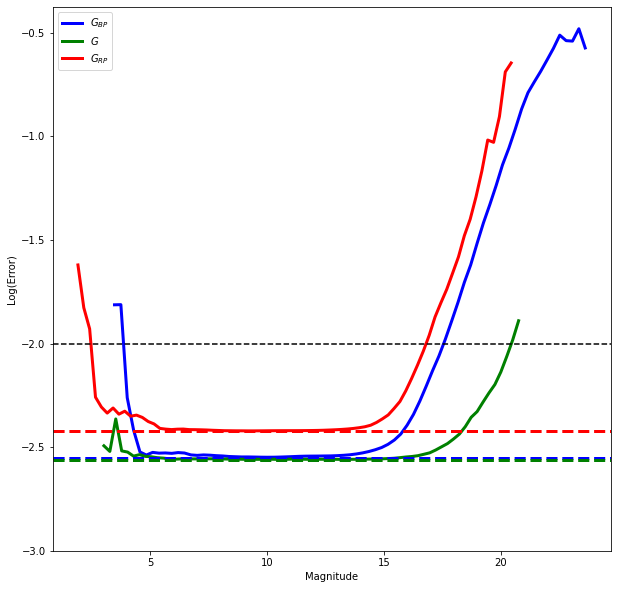

In [5]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Fit the errors
bp_fin = np.where(np.isfinite(bpbin)==True)
g_fin = np.where(np.isfinite(gbin)==True)
rp_fin = np.where(np.isfinite(rpbin)==True)

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum)[bp_fin],bpbin[bp_fin])
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum)[g_fin],gbin[g_fin])
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum)[rp_fin],rpbin[rp_fin])

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.axhline(np.log10(0.0027901700),lw=3.0,c='blue',ls='--')
plt.axhline(np.log10(0.0027553202),lw=3.0,c='green',ls='--')
plt.axhline(np.log10(0.0037793818),lw=3.0,c='red',ls='--')
plt.axhline(np.log10(0.01),c='k',ls='--')
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');
# plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight')

<ipython-input-6-a6a66cc8681b>:27: RuntimeWarning: divide by zero encountered in log10
  hmaherr = np.log10(allStar['H_ERR'][h_fin])


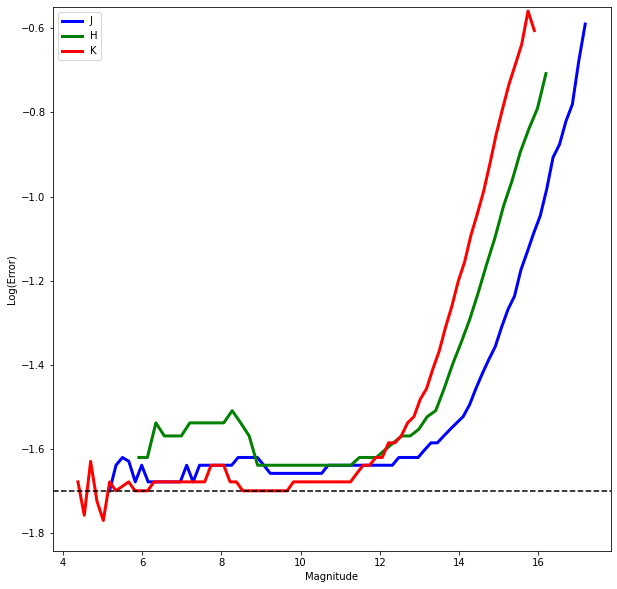

In [6]:
allStar = Table(fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz'))
allStar = allStar['APOGEE_ID','FE_H','FE_H_ERR','J','H','K','J_ERR','H_ERR','K_ERR']

binnum = 75

### J
j_fin = np.where((np.isfinite(allStar['J'])==True)&(allStar['J']<50.)&
                 (np.isfinite(allStar['J_ERR'])==True)&(allStar['J_ERR']<1.))

jmin = min(allStar['J'][j_fin])
jmax = max(allStar['J'][j_fin])

jdiff = jmax-jmin
jmaherr = np.log10(allStar['J_ERR'][j_fin])

jbin ,_,_ = binned_statistic(allStar['J'][j_fin],jmaherr,'median',bins=binnum)
jerrfunc = bspline(np.arange(jmin,jmax,jdiff/binnum),jbin)

### H
h_fin = np.where((np.isfinite(allStar['H'])==True)&(allStar['H']<50.)&
                 (np.isfinite(allStar['H_ERR'])==True)&(allStar['H_ERR']<1.))

hmin = min(allStar['H'][h_fin])
hmax = max(allStar['H'][h_fin])

hdiff = hmax-hmin
hmaherr = np.log10(allStar['H_ERR'][h_fin])

hbin ,_,_ = binned_statistic(allStar['H'][h_fin],hmaherr,'median',bins=binnum)
herrfunc = bspline(np.arange(hmin,hmax,hdiff/binnum),hbin)

### K
k_fin = np.where((np.isfinite(allStar['K'])==True)&(allStar['K']<50.)&
                 (np.isfinite(allStar['K_ERR'])==True)&(allStar['K_ERR']<1.))

kmin = min(allStar['K'][k_fin])
kmax = max(allStar['K'][k_fin])

kdiff = kmax-kmin
kmaherr = np.log10(allStar['K_ERR'][k_fin])

kbin ,_,_ = binned_statistic(allStar['K'][k_fin],kmaherr,'median',bins=binnum)
kerrfunc = bspline(np.arange(kmin,kmax,kdiff/binnum),kbin)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(jmin,jmax,jdiff/binnum),jbin,lw=3.0,c='blue',label=r'J')
plt.plot(np.arange(hmin,hmax,hdiff/binnum),hbin,lw=3.0,c='green',label=r'H')
plt.plot(np.arange(kmin,kmax,kdiff/binnum),kbin,lw=3.0,c='red',label=r'K')
plt.legend()
plt.axhline(np.log10(0.02),c='k',ls='--')
plt.ylim(top=-0.55)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');
# plt.savefig('../plots/2masserrorcurve.pdf',dpi=300,bbox_inches='tight')

### Calculate Errors for NaNs
jerr = 999999.0*np.ones(len(kdr17))
herr = 999999.0*np.ones(len(kdr17))
kerr = 999999.0*np.ones(len(kdr17))

for i in range(len(kdr17)):
    if np.isfinite(kdr17['J_ERR'][i])==False:
        jerr[i] = 10**jerrfunc(kdr17['J'][i])
    else:
        jerr[i] = kdr17['J_ERR'][i]
        
    if np.isfinite(kdr17['H_ERR'][i])==False:
        herr[i] = 10**herrfunc(kdr17['H'][i])
    else:
        herr[i] = kdr17['H_ERR'][i]
        
    if np.isfinite(kdr17['K_ERR'][i])==False:
        kerr[i] = 10**kerrfunc(kdr17['K'][i])
    else:
        kerr[i] = kdr17['K_ERR'][i]
        
### Replace nan's with zeropoint error
jerr = np.nan_to_num(jerr,nan=0.02)
herr = np.nan_to_num(herr,nan=0.02)
kerr = np.nan_to_num(kerr,nan=0.02)

In [7]:
from scipy.interpolate import BSpline


teff_tck = (np.array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102, 3708.91847923, 3890.36991744, 
                      4071.82144442, 4253.27263849, 4434.72434304, 4616.17578125, 4797.62695312, 4979.07848011,
                      5160.53018466, 5341.98144531, 5523.43261719, 5523.43261719, 5523.43261719, 5523.43261719]),
            np.array([ -36.38271977,  -43.37201334,  -17.08585409,   67.8896712 , 69.84606503,  100.46933976,  
                      103.94758719,   75.90855137,60.21227975,   -5.14343676,   -6.42134699,  217.36965544,
                      -447.26168354, -197.7697192 ,    0.        ,    0.        , 0.        ,    0.        ]),3)


tcorr_spl = BSpline(teff_tck[0],teff_tck[1],teff_tck[2])

tcorr = tcorr_spl(kdr17['FPARAM'][:,0])+kdr17['FPARAM'][:,0]

mh_tck = (np.array([-2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -1.96716837e+00,
                    -1.71575650e+00, -1.46434463e+00, -1.21293276e+00, -9.61520889e-01, -7.10109077e-01,
                    -4.58697175e-01, -2.07285313e-01, 4.41265486e-02, 2.95538409e-01, 5.46950281e-01, 
                    5.46950281e-01, 5.46950281e-01, 5.46950281e-01]),
          np.array([1.12848696e+02, 1.00546777e+02, 1.15992357e+02, 9.79509398e+01, 3.87315323e+01, 
                    1.86357031e+01, -1.50821811e+01, 1.21509274e+01, 6.69424869e+00, -2.90025110e+00,
                    -2.68067104e+01, -3.13392475e+01, -8.25826363e+01,-6.49082047e+01, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),3)

teff_cal = BSpline(mh_tck[0],mh_tck[1],mh_tck[2])(kdr17['FPARAM'][:,3])+tcorr

In [9]:
kasc_data = Table(kdr17)['TEFF','TEFF_ERR','LOGG','LOGG_ERR','FE_H','FE_H_ERR','GAIAEDR3_PHOT_BP_MEAN_MAG',
                          'GAIAEDR3_PHOT_G_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J','H','K']

kasc_data['GAIAEDR3_PHOT_G_MEAN_MAG'].name = 'G'
kasc_data['GAIAEDR3_PHOT_RP_MEAN_MAG'].name = 'RP'
kasc_data['GAIAEDR3_PHOT_BP_MEAN_MAG'].name = 'BP'

kasc_data['TEFF'] = teff_cal

kasc_data.add_column(apoafe, name='ALPHA_FE')
kasc_data.add_column(apoafe_err, name='ALPHA_FE_ERR')
kasc_data.add_column((1/kdr17['GAIAEDR3_PARALLAX'][i])*1000, name='DISTANCE')

kasc_data.add_column(jerr, name='J_ERR')
kasc_data.add_column(herr, name='H_ERR')
kasc_data.add_column(kerr, name='K_ERR')

kasc_data.add_column(bperr, name='BP_ERR')
kasc_data.add_column(gerr, name='G_ERR')
kasc_data.add_column(rperr, name='RP_ERR')

In [17]:
# lite = np.arange(len(kasc_data))[::12]

kasc_ext = 999999.0*np.ones((len(kasc_data),6))
kasc_ext_err = 999999.0*np.ones((len(kasc_data),6))

kasc_age_3 = 999999.0*np.ones(len(kasc_data))
kasc_age_err_3 = 999999.0*np.ones(len(kasc_data))
kasc_chi_3 = 999999.0*np.ones(len(kasc_data))
kasc_rms_3 = 999999.0*np.ones(len(kasc_data))
kasc_d_int_IMF_3 = 999999.0*np.ones(len(kasc_data))

kasc_age_7 = 999999.0*np.ones(len(kasc_data))
kasc_age_err_7 = 999999.0*np.ones(len(kasc_data))
kasc_chi_7 = 999999.0*np.ones(len(kasc_data))
kasc_rms_7 = 999999.0*np.ones(len(kasc_data))
kasc_d_int_IMF_7 = 999999.0*np.ones(len(kasc_data))
# kasc_mass = 999999.0*np.ones(len(kasc_data))
# kasc_mass_err = 999999.0*np.ones(len(kasc_data))


for i in tqdm(range(len(kasc_data))):
    
    CalcAge = Aetas(kasc_data[i],massive,teff_extrap_limit=200)#,debug=True)
    
    # Run Extinctions
    kasc_ext[i,:],kasc_ext_err[i,:] = CalcAge.extinction()
    
    # get weighted age, age error, age chi, age RMS, delta int_IMF, mass, and mass error
    result_3 = CalcAge.get_age(label=3,extrap=True,guess_ages=np.linspace(0.012,17.)[::10],maxfev=5000)
    result_7 = CalcAge.get_age(label=7,extrap=True,guess_ages=np.linspace(0.012,17.)[::10],maxfev=5000)
    
    kasc_age_3[i],kasc_age_err_3[i],kasc_chi_3[i],kasc_rms_3[i],kasc_d_int_IMF_3[i] = result_3
    kasc_age_7[i],kasc_age_err_7[i],kasc_chi_7[i],kasc_rms_7[i],kasc_d_int_IMF_7[i] = result_7
#     kasc_age[i],kasc_age_err[i],kasc_chi[i],kasc_rms[i],kasc_d_int_IMF[i],kasc_mass[i],kasc_mass_err[i]=wgt_result

  0%|          | 0/6099 [00:00<?, ?it/s]

<ipython-input-1-185f0a42499c>:517: RuntimeWarning: invalid value encountered in log10
  lgage = np.log10(age*10**9)


In [18]:
parsec_age = 999999.0*np.ones(len(kdr17))

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mass_2_age_PARSEC(mass,salfeh,teff,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        teff: teff
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    test = np.where((isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
#     pdb.set_trace()
    
    idx_lo = np.where((isochrones['MH']==feh_lo)&
                                 (isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
    iso_lo = isochrones[idx_lo]
    
    idx_hi = np.where((isochrones['MH']==feh_hi)&
                                 (isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
    iso_hi = isochrones[idx_hi]
    
    try:
        # lower [Fe/H]
        sidx_lo = np.argsort(iso_lo['Mass'])
        smass_lo = iso_lo['Mass'][sidx_lo]
        _,uidx_lo = np.unique(smass_lo,return_index=True)
        smass_lo = smass_lo[uidx_lo]
        sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

        spl_lo = interp1d(smass_lo,sage_lo)

        # higher [Fe/H]
        sidx_hi = np.argsort(iso_hi['Mass'])
        smass_hi = iso_hi['Mass'][sidx_hi]
        _,uidx_hi = np.unique(smass_hi,return_index=True)
        smass_hi = smass_hi[uidx_hi]
        sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

        spl_hi = interp1d(smass_hi,sage_hi)

        # final spline
        final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
        age = final_spl(salfeh)
        return age
    except:
        return 999999.0

for i in tqdm(range(len(kdr17))):
    parsec_age[i] = mass_2_age_PARSEC(k674['APOKASC3P_MASS'][i],salfeh[i],teff_cal[i],massive[np.where(massive['label']==3)])

  0%|          | 0/6099 [00:00<?, ?it/s]

(array([  0.,  13.,  66., 150., 189., 276., 277., 324., 335., 297., 317.,
        271., 251., 280., 214., 265., 208., 197., 182., 218., 155., 156.,
        159., 119., 143., 123., 128., 123., 110.,  95.,  91.,  44.,  30.,
         29.,  21.,  12.,   9.,  12.,  13.,  11.,   6.,   2.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
        13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
        17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ]),
 <BarContainer object of 50 artists>)

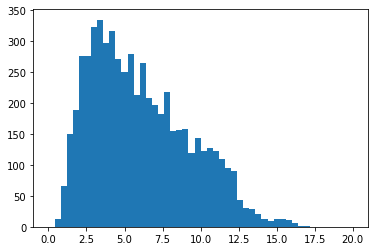

In [14]:
plt.hist(parsec_age,bins=50,range=(0,20))

(0.0, 20.0)

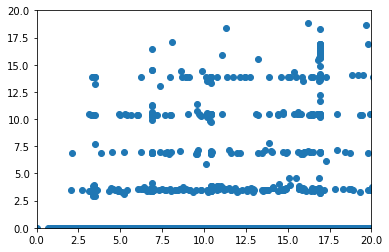

In [20]:
plt.scatter(kasc_age_3,kasc_age_7)
plt.xlim(0,20)
plt.ylim(0,20)

In [24]:
kasc_chi_3

array([9.99999000e+05, 2.78648030e+02, 9.81741569e+01, ...,
       3.05220386e+01, 1.87232869e+05, 4.87831948e+00])

In [22]:
kasc_age_3

array([9.99999000e+05, 1.39670506e+01, 3.42460138e+00, ...,
       4.08227710e+01, 1.69500125e+01, 9.99999000e+05])

In [25]:
kasc_age_7

array([9.99999000e+05, 1.20000000e-02, 1.20000000e-02, ...,
       1.20000000e-02, 1.69500117e+01, 6.82480166e+00])

In [21]:
kasc_d_int_IMF_7

array([ 9.99999000e+05,  9.99999000e+05,  9.99999000e+05, ...,
        9.99999000e+05,  9.33230066e-06, -5.39162955e-06])

In [17]:
from astropy.table import Table, Column

cname = Column(kdr17['APOGEE_ID'], name='NAME')#

cext = Column(kasc_ext,name='EXT')#
cext_err = Column(kasc_ext_err,name='EXT_ERR')#

cage = Column(kasc_age,name='AGE')#
cage_err = Column(kasc_age_err,name='AGE_ERR')#
cchi = Column(kasc_chi,name='AGE_CHI')#
crms = Column(kasc_rms,name='AGE_RMSE')#

cpage = Column(parsec_age,name='PARSEC_AGE')#

cmass = Column(kasc_mass,name='MASS')#
cmass_err = Column(kasc_mass,name='MASS_ERR')#

cd_int_IMF = Column(kasc_d_int_IMF,name='DELTA_INT_IMF')#

cjage = Column(k674['A3P_AGEMOD_JT'],name='A3P_AGE_JT')#
cjmass = Column(k674['APOKASC3P_MASS'],name='APOKASC3P_MASS')#

agetable = Table([cname,cext,cext_err,cage,cage_err,cchi,crms,cpage,cmass,cmass_err,cd_int_IMF,cjage,cjmass])
# agetable.write('apokasc_lm_wgtage_20SEP2022.fits',format='fits', overwrite=True)

In [18]:
agetab = fits.getdata('apokasc_lm_wgtage_20SEP2022.fits')

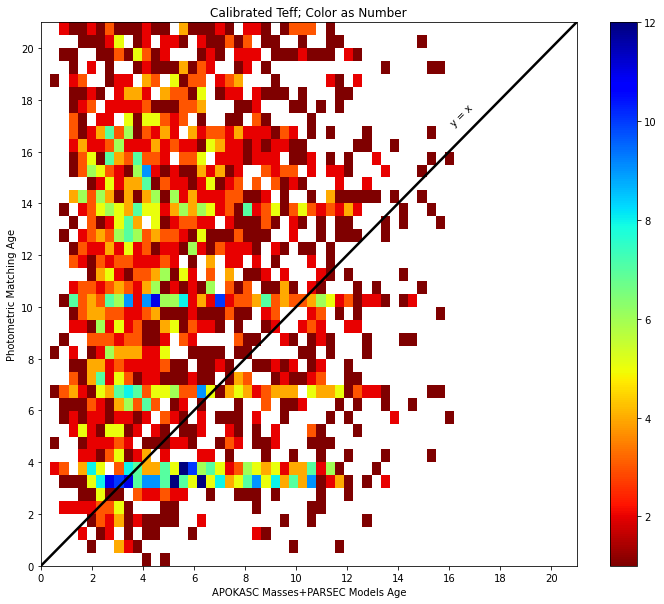

In [21]:
plt.figure(figsize=[12,10])
xmax = 18
ymax = 25
nbins = 50

age2age_fincut = np.where((np.isfinite(agetab['AGE'])==True)&(agetab['AGE']<100.)&
                         (np.isfinite(agetab['PARSEC_AGE'])==True)&
                         (agetab['PARSEC_AGE']<100.))

age2age_ret = binned_statistic_2d(agetab['PARSEC_AGE'],agetab['AGE'],
                                  agetab['PARSEC_AGE'],'count',
                                  bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/nbins)])

age2age_ret.statistic[age2age_ret.statistic == 0.0] = np.nan

im = plt.imshow(age2age_ret.statistic.T, origin='lower',
                extent=[age2age_ret.x_edge[0],age2age_ret.x_edge[-1],
                        age2age_ret.y_edge[0],age2age_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.plot([0,21],[0,21],lw=2.5,c='k')
# plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
# plt.plot([0,17.25],[4,17.25+4],lw=2.5,c='k')
# plt.plot([0,10.95],[11,11],lw=2.5,c='k')

# plt.plot([11,11],[0,5.5],c='k',lw=2.5)
# plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

xshift = 10
yshift = 10
plt.text(6+xshift,7+yshift,'y = x',rotation=45)
# plt.text(8+xshift,4.8+yshift,'y = x - 4',rotation=45)
# plt.text(4+xshift,8.8+yshift,'y = x + 4',rotation=45)
# plt.text(0.75,11.3,'y = 11')


plt.xlim(0,21)
plt.ylim(0,21)

plt.xticks(np.arange(0,21)[::2],np.arange(0,21)[::2].astype('str'))
plt.yticks(np.arange(0,21)[::2],np.arange(0,21)[::2].astype('str'))

plt.title(r'Calibrated Teff; Color as Number')
plt.xlabel(r'APOKASC Masses+PARSEC Models Age')
plt.ylabel(r'Photometric Matching Age')

plt.savefig('kasc_age2age_wgtage.png',bbox_inches='tight')
plt.show()

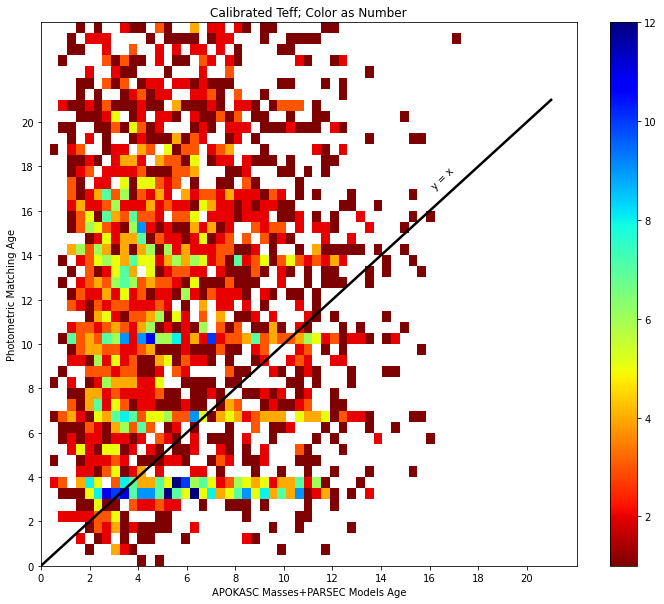

In [23]:
plt.figure(figsize=[12,10])
xmax = 18
ymax = 25
nbins = 50

age2age_fincut = np.where((np.isfinite(agetab['AGE'])==True)&(agetab['AGE']<100.)&
                         (np.isfinite(agetab['PARSEC_AGE'])==True)&
                         (agetab['PARSEC_AGE']<100.))

age2age_ret = binned_statistic_2d(agetab['PARSEC_AGE'],agetab['AGE'],
                                  agetab['PARSEC_AGE'],'count',
                                  bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/nbins)])

age2age_ret.statistic[age2age_ret.statistic == 0.0] = np.nan

im = plt.imshow(age2age_ret.statistic.T, origin='lower',
                extent=[age2age_ret.x_edge[0],age2age_ret.x_edge[-1],
                        age2age_ret.y_edge[0],age2age_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.plot([0,21],[0,21],lw=2.5,c='k')
# plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
# plt.plot([0,17.25],[4,17.25+4],lw=2.5,c='k')
# plt.plot([0,10.95],[11,11],lw=2.5,c='k')

# plt.plot([11,11],[0,5.5],c='k',lw=2.5)
# plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

xshift = 10
yshift = 10
plt.text(6+xshift,7+yshift,'y = x',rotation=45)
# plt.text(8+xshift,4.8+yshift,'y = x - 4',rotation=45)
# plt.text(4+xshift,8.8+yshift,'y = x + 4',rotation=45)
# plt.text(0.75,11.3,'y = 11')


# plt.xlim(0,21)
# plt.ylim(0,21)

plt.xticks(np.arange(0,21)[::2],np.arange(0,21)[::2].astype('str'))
plt.yticks(np.arange(0,21)[::2],np.arange(0,21)[::2].astype('str'))

plt.title(r'Calibrated Teff; Color as Number')
plt.xlabel(r'APOKASC Masses+PARSEC Models Age')
plt.ylabel(r'Photometric Matching Age')

plt.savefig('kasc_age2age_wgtage2.png',bbox_inches='tight')
plt.show()

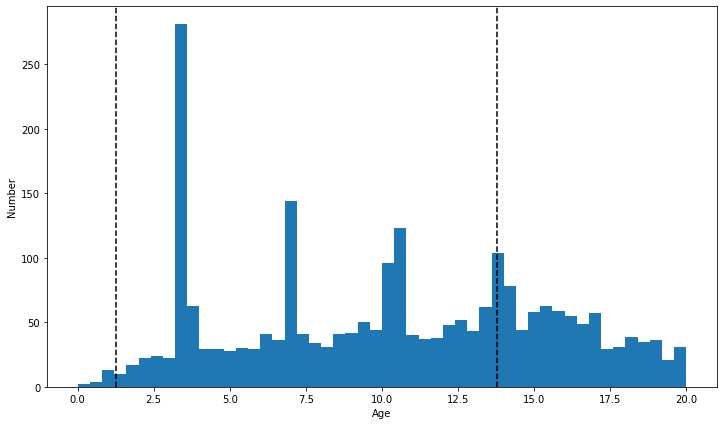

In [22]:
plt.figure(figsize=[12,7])
plt.hist(agetab['AGE'],range=(0,20),bins=50)
plt.axvline(1.25,c='k',ls='--')
plt.axvline(13.787,c='k',ls='--')
plt.xlabel(r'Age')
plt.ylabel(r'Number')
plt.savefig('lmc_lm_wgtage_hist.png',bbox_inches='tight')
plt.show()

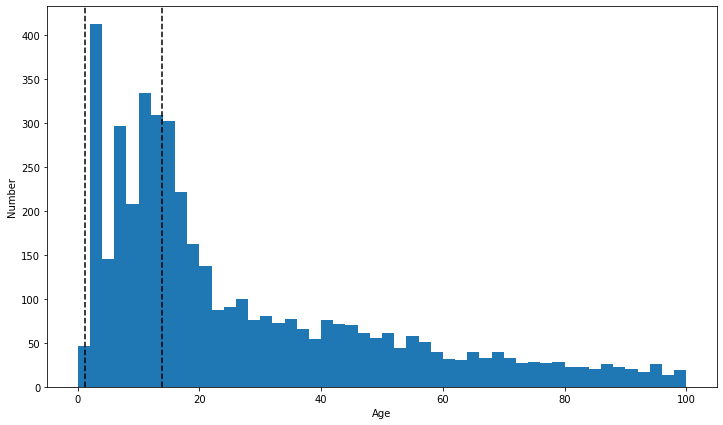

In [25]:
plt.figure(figsize=[12,7])
plt.hist(agetab['AGE'],range=(0,100),bins=50)
plt.axvline(1.25,c='k',ls='--')
plt.axvline(13.787,c='k',ls='--')
plt.xlabel(r'Age')
plt.ylabel(r'Number')
plt.savefig('lmc_lm_wgtage_hist2.png',bbox_inches='tight')
plt.show()

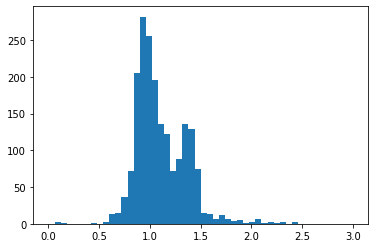

In [33]:
plt.hist(agetab['MASS'],range=(0,3),bins=50)
plt.savefig('wgtage_mass.png',bbox_inches='tight')

# Single Bad Star

In [34]:
np.where((agetab['AGE']>35.)&(agetab['AGE']<45.))

(array([  26,   30,   76,  103,  126,  129,  136,  145,  200,  212,  219,
         223,  244,  245,  254,  258,  261,  307,  321,  322,  353,  369,
         373,  376,  461,  465,  470,  472,  473,  514,  530,  572,  582,
         609,  626,  668,  673,  696,  734,  744,  767,  772,  832,  841,
         848,  877,  892,  910,  921,  925,  943,  944,  971,  981,  983,
         998, 1053, 1099, 1102, 1122, 1158, 1191, 1232, 1276, 1284, 1293,
        1297, 1320, 1335, 1353, 1358, 1387, 1391, 1421, 1463, 1468, 1484,
        1509, 1512, 1515, 1525, 1549, 1574, 1598, 1630, 1635, 1666, 1709,
        1747, 1753, 1842, 1898, 1916, 1935, 1960, 1961, 1971, 1975, 1986,
        1987, 2036, 2053, 2056, 2067, 2089, 2144, 2162, 2163, 2170, 2174,
        2196, 2214, 2242, 2261, 2273, 2287, 2295, 2353, 2355, 2356, 2383,
        2384, 2390, 2410, 2428, 2455, 2468, 2506, 2527, 2621, 2635, 2641,
        2669, 2673, 2684, 2704, 2714, 2726, 2730, 2801, 2824, 2851, 2853,
        2866, 2869, 2871, 2963, 2970, 

In [38]:
agetab['AGE'][3613]

39.45140846961177

In [39]:
kasc_age[3613]

39.45140846961177

In [40]:
star_ext = 999999.0*np.ones(6)
star_ext_err = 999999.0*np.ones(6)
star_age = 999999.0
star_age_err = 999999.0
star_chi = 999999.0
star_rms = 999999.0
star_d_int_IMF = 999999.0
star_mass = 999999.0
star_mass_age = 999999.0

i = 3613
CalcAge = Aetas(kasc_data[i],massive,teff_extrap_limit=200,debug=True)
    
# Run Extinctions
star_ext,star_ext_err = CalcAge.extinction()

print('####################################################################')

print(CalcAge.get_age(label=7,extrap=True,guess_ages=np.linspace(0.012,17.)[::10],maxfev=5000))

print('####################################################################')

# get weighted age, age error, age chi, age RMS, delta int_IMF, mass, and mass error
wgt_result = CalcAge.weighted_age_mass()
atsr_age,star_age_err,star_chi,star_rms,star_d_int_IMF,star_mass,star_mass_err=wgt_result

### Running Aetas.extinction() ###
Inputs from Aetas.__init__()
Salaris Corrected Metallicity: -0.01796571759902575
Temperature: 4605.957383166968
Calculated Observed Colors:
Observed Colors: [0.58949947 0.72790051 1.65849972 2.21549988 2.35850048]
Observed Color Errors: [0.0039928  0.00469323 0.01821138 0.01722366 0.02019045]
Isochrone Colors: [0.56559484 0.71458369 1.6206736  2.20126343 2.30646146]
A(G)+ Error: 0.047193669273458146 0.02512258324978168
All Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
chisq: 14.082198488050764
resid: [ 0.01360611  0.00246509  0.00680145 -0.02271524  0.01133842]
####################################################################
Running Aetas.get_age()
guess_ages: [1.20000000e-02 3.47893878e+00 6.94587755e+00 1.04128163e+01
 1.38797551e+01]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [0.02499999950079735, 0.0

Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.3749706469138547]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.4749615216713865]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.4749615216713865]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.4749615216713865]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.4749615216713865]
Running Aetas.teff_2_appmags()

[age_lo,age_hi]:  [0.02499999950079735, 0.07499978182030029]
outside iso_lo
Age 0.02499999950079735
max iso_lo 3.6138
min iso_lo 3.5657
Teff 3.6633199153170866
Lower - Teff -927.2097135028403
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [0.02499999950079735, 0.07499978182030029]
outside iso_lo
Age 0.02499999950079735
max iso_lo 3.6138
min iso_lo 3.5657
Teff 3.6633199153170866
Lower - Teff -927.2097135028403
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [0.02499999950079735, 0.07499978182030029]
outside iso_lo
Age 0.02499999950079735
max iso_lo 3.6138
min iso_lo 3.5657
Teff 3.6633199153170866
Lower - Teff -927.2097135028403
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:

[age_lo,age_hi]:  [10.399920034503666, 10.450089259696478]
outside iso_lo
Age 10.399920034503666
max iso_lo 3.64
min iso_lo 3.4652
Teff 3.6633199153170866
Lower - Teff -1687.1865349698255
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [10.399920034503666, 10.450089259696478]
outside iso_lo
Age 10.399920034503666
max iso_lo 3.64
min iso_lo 3.4652
Teff 3.6633199153170866
Lower - Teff -1687.1865349698255
Calc App Mags + logg: [999999. 999999. 999999. 999999. 999999. 999999. 999999.]
Observed Mags + logg: [12.78899956 12.19950008 11.47159958 10.54100037  9.98400021  9.8409996
  2.63912487]
Observed Mags + logg Errors: [0.01       0.01       0.01       0.018      0.017      0.02
 0.02203981]
4 10.412816326530612 10.412816326530612 4.1104280181024376e+16 3.1451043736936586
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.

Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [6.925003544081933, 6.974932354244468]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [11.399872655699784, 11.350108156723143]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [11.399872655699784, 11.350108156723143]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [17.000042221563632, 16.950011609551062]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [17.000042221563632, 16.950011609551062]
Running Aetas.teff_2_appmag

Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.4749615216713865, 3.525007131852038]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.4749615216713865, 3.525007131852038]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.4749615216713865, 3.525007131852038]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.3249873702294206, 3.3749706469138547]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.3249873702294206, 3.3749706469138547]
Running Aetas.teff_2_appmags

Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.4749615216713865]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.4749615216713865]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.4749615216713865]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.3749706469138547]
Running Aetas.teff_2_appmags()
Teff: 4605.957383166968
Extinctions: [0.05749219 0.04719367 0.03634194 0.01616901 0.01024198 0.00649306]
[age_lo,age_hi]:  [3.424995458816092, 3.3749706469138547]
Running Aetas.teff_2_appmags()

In [42]:
i

3613

In [44]:
kdr17['APOGEE_ID'][i]==agetab['NAME'][i]

True